In [1]:
# Librerias a utilizar

import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import re

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
import pickle
# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

**I. Lectura del archivo**

In [2]:
# Data de training
data_training = pd.read_csv("C://Users//faman//Desktop//Master Big Data UCM//Curso 8. Machine Learning//evaluacion//training.csv", parse_dates = ["date_recorded"])
data_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55763 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59398 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

In [3]:
# Data de test
data_test = pd.read_csv("C://Users//faman//Desktop//Master Big Data UCM//Curso 8. Machine Learning//evaluacion//test.csv")
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [4]:
data_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [5]:
# Labels
data_labels = pd.read_csv("C://Users//faman//Desktop//Master Big Data UCM//Curso 8. Machine Learning//evaluacion//labels.csv")
data_labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


**Separamos las columnas de acuerdo a si son categóricas o numéricas**

In [6]:
cat_cols= data_training.select_dtypes(include=['object','category']).columns
num_cols = data_training.select_dtypes(exclude=['object','category']).columns

In [7]:
data_training[cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1896,2145,37399,9,19287,21,125,2092,2,1,...,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,9084,17402,3563,10248,508,5294,2503,307,51011,59400,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


**La idea ahora es pre-procesar los datos**

**II. Tratamiento de variables numéricas**

In [8]:
data_training[num_cols].describe()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,2012-03-29 09:11:33.818181888,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
min,0.000000,0.000000,2002-10-14 00:00:00,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,2011-04-01 00:00:00,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,2012-10-10 00:00:00,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,2013-02-09 00:00:00,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2013-12-03 00:00:00,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
std,21453.128371,2997.574558,NaN,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547


**1. latitud y longitud**

**Examinemos las distribuciones de ambas variables**

              Valor  Frecuencia
0     -2.000000e-08        1812
1     -6.985842e+00           2
2     -6.980220e+00           2
3     -2.476680e+00           2
4     -6.978263e+00           2
...             ...         ...
57512 -3.287619e+00           1
57513 -8.234989e+00           1
57514 -3.268579e+00           1
57515 -1.146053e+01           1
57516 -6.747464e+00           1

[57517 rows x 2 columns]


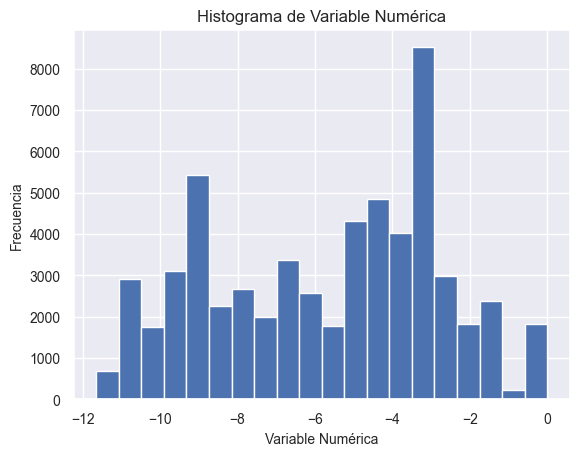

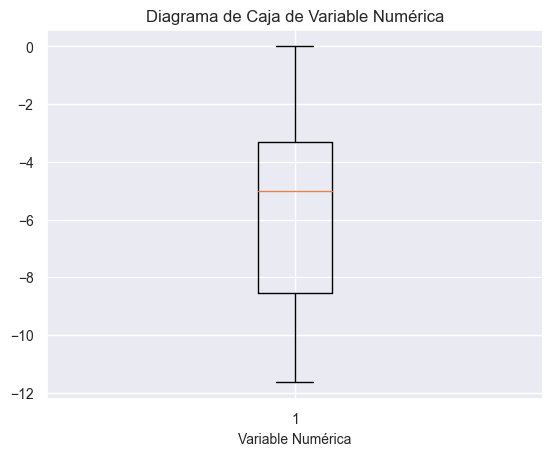

In [9]:
#Latitud

tabla_frecuencias = data_training['latitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

# histograma
plt.hist(data_training['latitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['latitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**Esta variable estaría bien, ya que sigue una distribución relativamente normal y no tiene outliers**

           Valor  Frecuencia
0       0.000000        1812
1      37.375717           2
2      38.340501           2
3      39.086183           2
4      33.005032           2
...          ...         ...
57511  35.885754           1
57512  36.626541           1
57513  37.333530           1
57514  38.970078           1
57515  38.104048           1

[57516 rows x 2 columns]


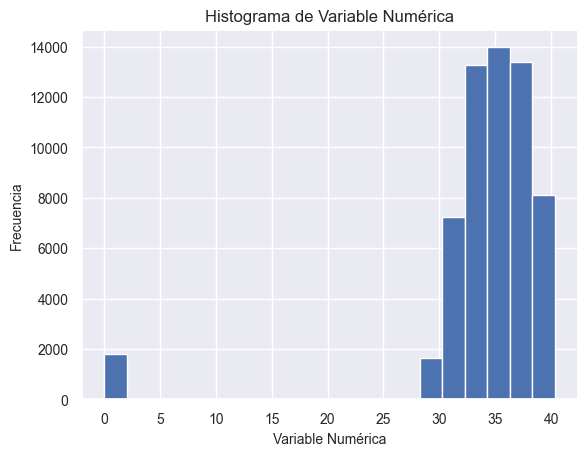

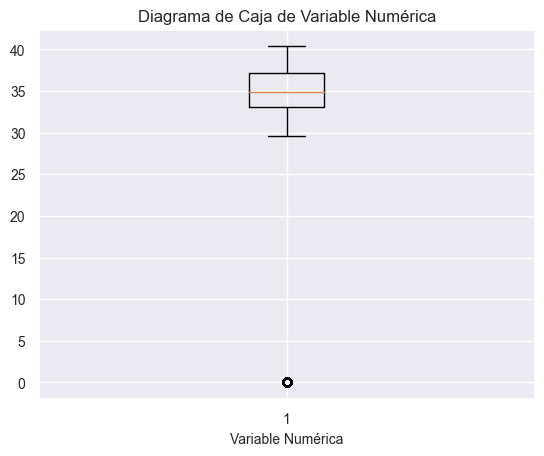

In [10]:
#Longitud

tabla_frecuencias = data_training['longitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)


# histograma
plt.hist(data_training['longitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['longitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()


**Esta variable si tiene problemas, por los valores 0, que representan un porcentaje no menor de los datos. Se asumiría que son valores nulos, por lo que se procederá a aplicar alguna técnica de imputación**

In [11]:
import numpy as np

# Convertir los valores 0 en nulos en la columna 'longitud'
data_training['longitude'] = data_training['longitude'].replace(0, np.nan)



In [12]:
from sklearn.impute import KNNImputer

# Aplicar imputación por KNN a la columna 'longitud'
imputer = KNNImputer(n_neighbors=5)
data_training['longitude'] = imputer.fit_transform(data_training[['longitude']])


           Valor  Frecuencia
0      35.149669        1812
1      37.375717           2
2      38.340501           2
3      39.086183           2
4      33.005032           2
...          ...         ...
57511  35.885754           1
57512  36.626541           1
57513  37.333530           1
57514  38.970078           1
57515  38.104048           1

[57516 rows x 2 columns]


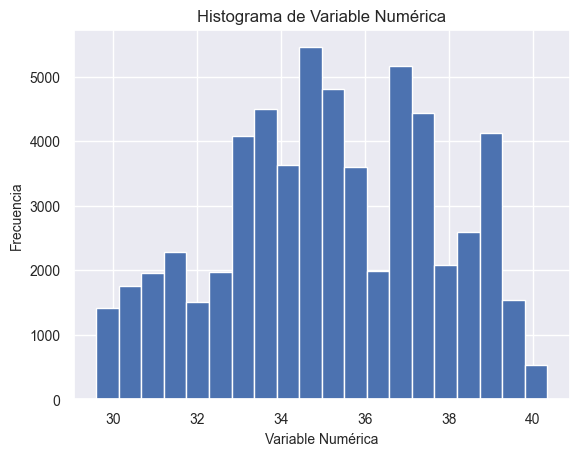

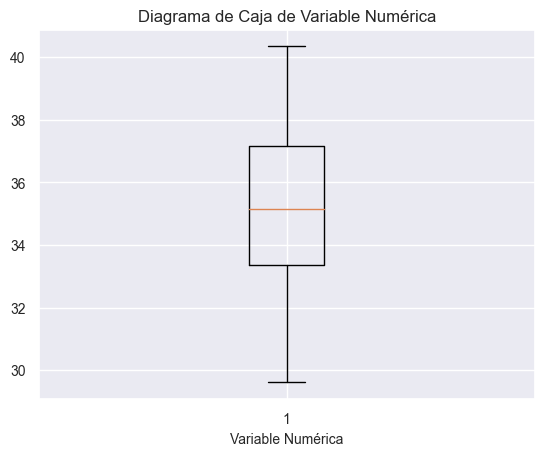

In [13]:
#Verificamos ahora como quedó la variable

tabla_frecuencias = data_training['longitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)


# histograma
plt.hist(data_training['longitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['longitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**Como resultado, la variable mejoró bastante con la imputación**

**Ahora repetimos el proceso con el dataset de test, analizando primero la distribución y luego imputando en caso de ser necesario**

              Valor  Frecuencia
0     -2.000000e-08         457
1     -7.105919e+00           2
2     -6.990042e+00           2
3     -7.170666e+00           2
4     -2.474560e+00           2
...             ...         ...
14385 -3.305540e+00           1
14386 -8.547786e+00           1
14387 -3.330889e+00           1
14388 -7.061047e+00           1
14389 -1.122601e+01           1

[14390 rows x 2 columns]


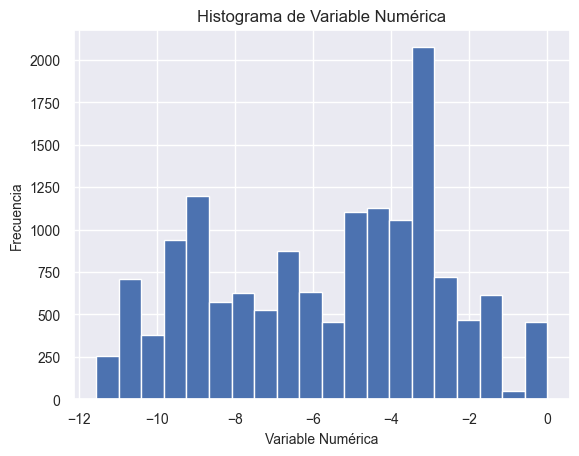

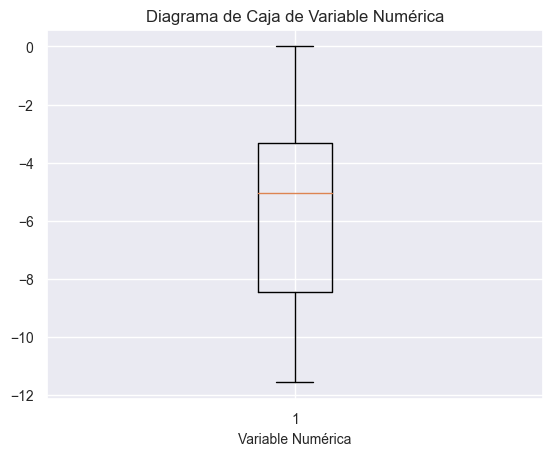

In [14]:
#Dataset de test

#Latitud

tabla_frecuencias = data_test['latitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)


# histograma
plt.hist(data_test['latitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_test['latitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**Esta variable estaría ok, ya que sigue una distribución similar a la del dataset de training, sin outliers**

           Valor  Frecuencia
0       0.000000         457
1      37.260069           2
2      39.080573           2
3      37.302281           2
4      32.920579           2
...          ...         ...
14385  36.648520           1
14386  35.265755           1
14387  36.666660           1
14388  37.830317           1
14389  34.765054           1

[14390 rows x 2 columns]


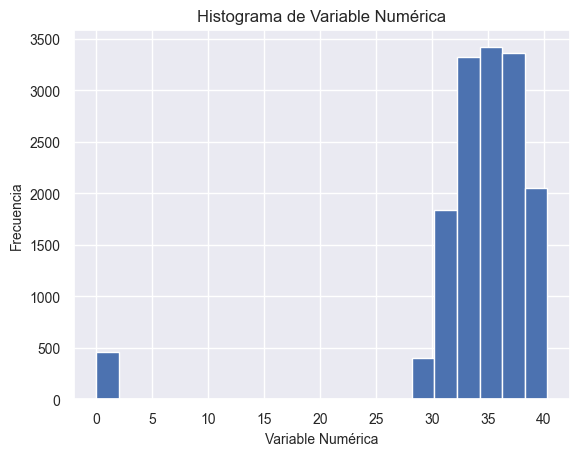

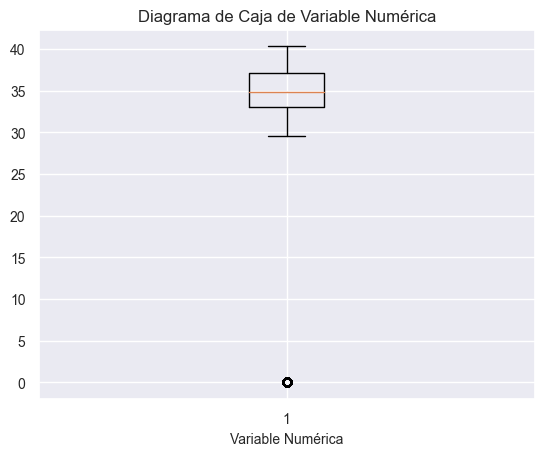

In [15]:
#Longitud

tabla_frecuencias = data_test['longitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)


# histograma
plt.hist(data_test['longitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_test['longitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**Esta variable, al igual que sucedió con el dataset de training, si tiene problemas, por los valores 0, que representan un porcentaje no menor de los datos. Se asumiría que son valores nulos, por lo que se procederá a aplicar alguna técnica de imputación. Se repetirá el proceso realizado con el dataset de training**

In [16]:
import numpy as np

# Convertir los valores 0 en nulos en la columna 'longitud'
data_test['longitude'] = data_test['longitude'].replace(0, np.nan)



In [17]:
from sklearn.impute import KNNImputer

# Aplicar imputación por KNN a la columna 'longitud'
imputer = KNNImputer(n_neighbors=5)
data_test['longitude'] = imputer.fit_transform(data_test[['longitude']])

           Valor  Frecuencia
0      35.143114         457
1      37.260069           2
2      39.080573           2
3      37.302281           2
4      32.920579           2
...          ...         ...
14385  36.648520           1
14386  35.265755           1
14387  36.666660           1
14388  37.830317           1
14389  34.765054           1

[14390 rows x 2 columns]


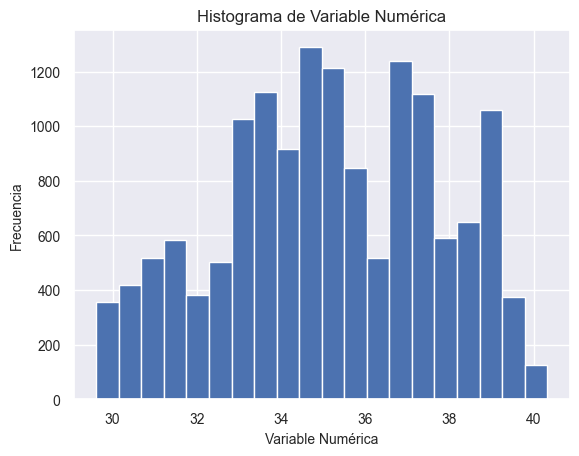

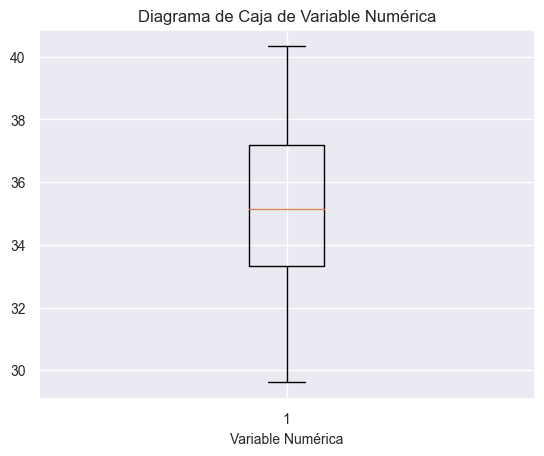

In [18]:
#Verificamos ahora como quedó la variable

tabla_frecuencias = data_test['longitude'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)


# histograma
plt.hist(data_test['longitude'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_test['longitude'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**Como resultado, la variable mejoró bastante con la imputación**

**2. data_recorded y num_private**

**Haciendo distintas pruebas, se llegó a la conclusión de que ambas variables no son relevantes para el modelo, por lo que se procederá a eliminar ambas de ambos datasets**

In [19]:

columnas_a_eliminar_training = ['date_recorded','num_private']
data_training = data_training.drop(columns=columnas_a_eliminar_training)

columnas_a_eliminar_test = ['date_recorded', 'num_private']
data_test = data_test.drop(columns=columnas_a_eliminar_test)


In [20]:
num_cols = data_training.select_dtypes(exclude=['object','category']).columns
data_training[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,35.149669,-5.706033e+00,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,2.567349,2.946019e+00,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,29.607122,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.354079,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,35.149669,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


In [21]:
# Ver asimetrías en las variables numéricas para ver que metodología emplear para tratar los outliers, en caso de que alguna variable tenga

data_training.select_dtypes(include=np.number).apply(lambda x: x.skew())

id                    0.002623
amount_tsh           57.807800
gps_height            0.462402
longitude            -0.136916
latitude             -0.152037
region_code           3.173818
district_code         3.962045
population           12.660714
construction_year    -0.634928
dtype: float64

En primera instancia, se observa que amount_tsh y population tiene asimetrías importantes

**1. amount_tsh**

In [22]:
#Definimos una función para gestionar outliers, y aplicarles winsorización a la que estimemos pertinente


def gestiona_outliers(col,clas = 'check'):
    
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

          
# Llamada en modo check
data_training.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))
data_test.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

id
amount_tsh
gps_height
longitude
latitude
region_code
district_code
population
construction_year
id
amount_tsh
gps_height
longitude
latitude
region_code
district_code
population
construction_year


C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.st

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,17.380471,0.0,0.0,0.0,4.060606,6.356902,3.380471,0.0
2,0.0,17.380471,0.0,0.0,0.0,4.060606,6.356902,3.380471,0.0


In [23]:
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))


In [24]:
# Crear copia para evitar pisar información
data_training_copy = data_training.select_dtypes(include=np.number).copy()
data_test_copy = data_test.select_dtypes(include=np.number).copy()

# Aplicar la gestión de outliers en modelo winsor
data_training_winsor = data_training_copy.apply(lambda x: gestiona_outliers(x,clas='winsor'))
data_test_winsor = data_test_copy.apply(lambda x: gestiona_outliers(x,clas='winsor'))

# Contemos si ha desaparecido algún resgitro o algo 
data_training_winsor.apply(lambda x: x.isna().sum()/x.count()*100)
data_test_winsor.apply(lambda x: x.isna().sum()/x.count()*100)

id
amount_tsh
gps_height
longitude
latitude
region_code
district_code
population
construction_year
id
amount_tsh
gps_height
longitude
latitude
region_code
district_code
population
construction_year


C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\4219387555.py:11: DeprecationWarning: Please use `median_abs_deviation` from the `scipy.stats` namespace, the `scipy.st

id                   0.0
amount_tsh           0.0
gps_height           0.0
longitude            0.0
latitude             0.0
region_code          0.0
district_code        0.0
population           0.0
construction_year    0.0
dtype: float64

In [25]:
#Verificamos ahora a través de la tabla de frecuencia de la variable, como quedó con la winsorización
tabla_frecuencias = data_training_winsor['amount_tsh'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

     Valor  Frecuencia
0     0.00       41639
1   100.00       11121
2    50.00        2472
3    20.00        1463
4    10.00         806
5    30.00         743
6     5.00         376
7    25.00         356
8     6.00         190
9     7.00          69
10   40.00          59
11   70.00          23
12   33.00          20
13   60.00          15
14   15.00          15
15    2.00          13
16   35.00           8
17    1.00           3
18    0.20           3
19   53.00           1
20   26.00           1
21    9.00           1
22    0.25           1
23   12.00           1
24   59.00           1


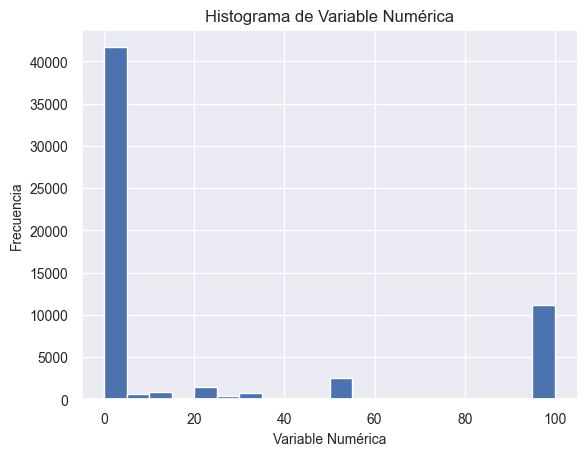

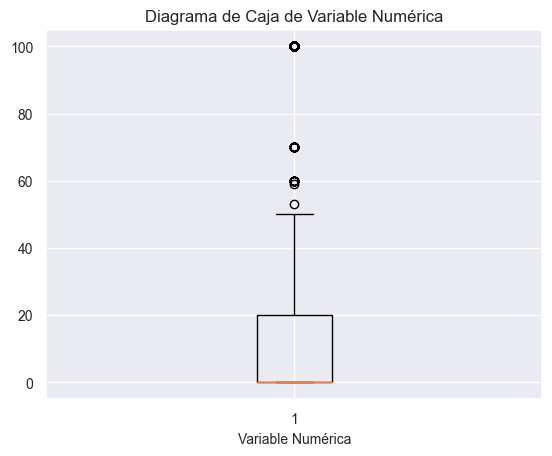

In [26]:
# histograma
plt.hist(data_training_winsor['amount_tsh'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training_winsor['amount_tsh'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

In [27]:
#Verificamos con un describe que la desviación estándar se redujo considrablemente, así como también sus valores máximos
num_cols = data_training_winsor.select_dtypes(exclude=['object','category']).columns
data_training_winsor[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,22.120149,668.297239,35.149669,-5.706033e+00,15.007323,4.560976,144.451953,1300.652475
std,21453.128371,38.969677,693.116350,2.567349,2.946019e+00,16.359443,5.215934,219.509982,951.620547
min,0.000000,0.000000,-90.000000,29.607122,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.354079,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,35.149669,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,100.000000,2770.000000,40.345193,-2.000000e-08,80.000000,23.000000,862.000000,2013.000000


In [28]:
# Ahora uniremos la columna amount_tsh del dataframe winsorizado a nuestro dataframe original

data_training = data_training.merge(data_training_winsor['amount_tsh'], left_index=True, right_index=True, suffixes=('', '_winsor'))
data_test = data_test.merge(data_test_winsor['amount_tsh'], left_index=True, right_index=True, suffixes=('', '_winsor'))



In [29]:
# Finalmente eliminamos la variable original (no winsorizada)
data_training.drop(columns='amount_tsh', inplace=True)
data_test.drop(columns='amount_tsh', inplace=True)


**2. Population**

      Valor  Frecuencia
0         0       21381
1         1        7025
2       200        1940
3       150        1892
4       250        1681
...     ...         ...
1044   6330           1
1045   5030           1
1046    656           1
1047    948           1
1048    788           1

[1049 rows x 2 columns]


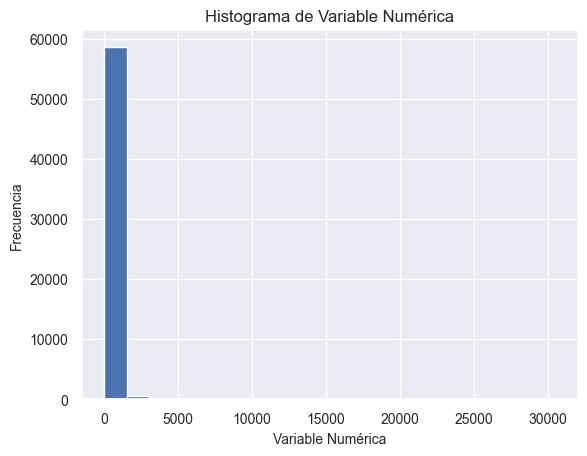

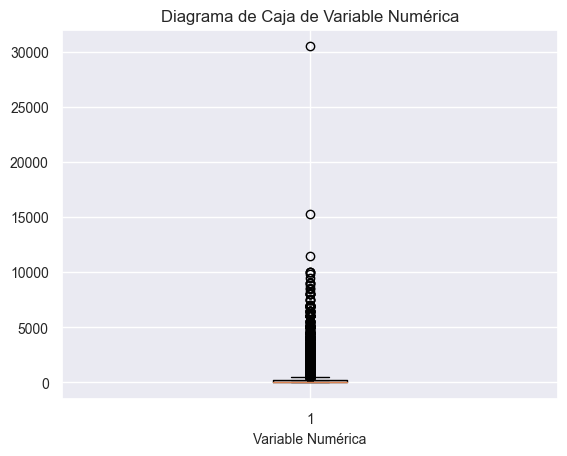

In [30]:
#Exploremos esta variable

tabla_frecuencias = data_training['population'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

# histograma
plt.hist(data_training['population'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['population'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

In [31]:

# Primero la convertimos a numérica
data_training['population'] = pd.to_numeric(data_training['population'])
data_test['population'] = pd.to_numeric(data_test['population'])

In [32]:
# Luego calculamos la media excluyendo los valores 0
media_poblacion_training = data_training.loc[data_training['population'] != 0, 'population'].mean()
data_training.loc[data_training['population'] == 0, 'population'] = media_poblacion_training

media_poblacion_test = data_test.loc[data_test['population'] != 0, 'population'].mean()
data_test.loc[data_test['population'] == 0, 'population'] = media_poblacion_test

# Redondear los valores imputados
data_training['population'] = data_training['population'].round()
data_test['population'] = data_test['population'].round()

C:\Users\faman\AppData\Local\Temp\ipykernel_22612\2774367354.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '281.08716694284436' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_training.loc[data_training['population'] == 0, 'population'] = media_poblacion_training
C:\Users\faman\AppData\Local\Temp\ipykernel_22612\2774367354.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '290.9541342981803' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_test.loc[data_test['population'] == 0, 'population'] = media_poblacion_test


       Valor  Frecuencia
0      281.0       21385
1        1.0        7025
2      200.0        1940
3      150.0        1892
4      250.0        1681
...      ...         ...
1043  6330.0           1
1044  5030.0           1
1045   656.0           1
1046   948.0           1
1047   788.0           1

[1048 rows x 2 columns]


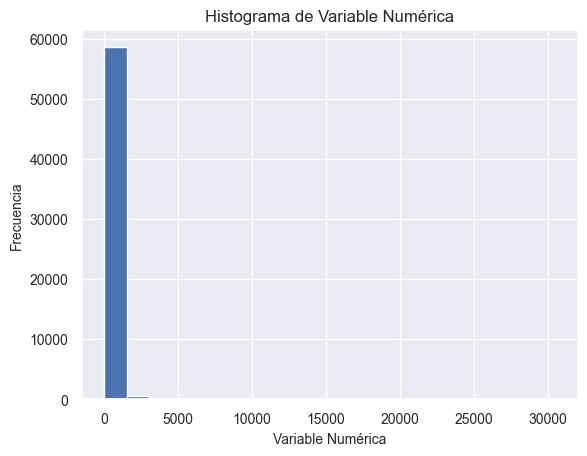

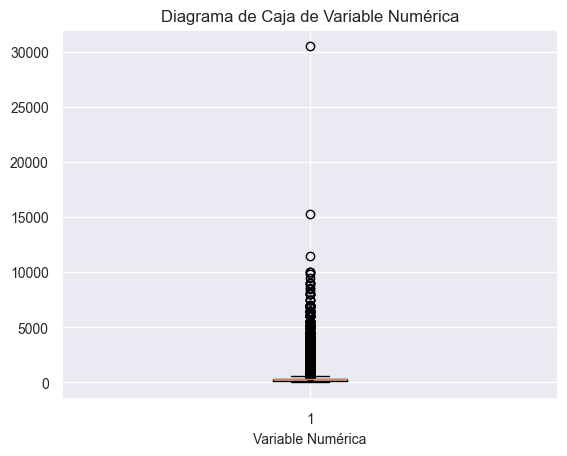

In [33]:
tabla_frecuencias = data_training['population'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

# histograma
plt.hist(data_training['population'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['population'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**2. construction_year**

In [34]:
tabla_frecuencias = data_training['construction_year'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

    Valor  Frecuencia
0       0       20709
1    2010        2645
2    2008        2613
3    2009        2533
4    2000        2091
5    2007        1587
6    2006        1471
7    2003        1286
8    2011        1256
9    2004        1123
10   2012        1084
11   2002        1075
12   1978        1037
13   1995        1014
14   2005        1011
15   1999         979
16   1998         966
17   1990         954
18   1985         945
19   1980         811
20   1996         811
21   1984         779
22   1982         744
23   1994         738
24   1972         708
25   1974         676
26   1997         644
27   1992         640
28   1993         608
29   2001         540
30   1988         521
31   1983         488
32   1975         437
33   1986         434
34   1976         414
35   1970         411
36   1991         324
37   1989         316
38   1987         302
39   1981         238
40   1977         202
41   1979         192
42   1973         184
43   2013         176
44   1971 

In [35]:
# Convertimos el tipo de variable
data_training['construction_year'] = pd.to_numeric(data_training['construction_year'])
data_test['construction_year'] = pd.to_numeric(data_test['construction_year'])

In [36]:
# Imputamos por la moda
moda_construccion_training = data_training.loc[data_training['construction_year'] != 0, 'construction_year'].mode()[0]
data_training.loc[data_training['construction_year'] == 0, 'construction_year'] = moda_construccion_training

moda_construccion_test = data_test.loc[data_test['construction_year'] != 0, 'construction_year'].mode()[0]
data_test.loc[data_test['construction_year'] == 0, 'construction_year'] = moda_construccion_test

    Valor  Frecuencia
0    2010       23354
1    2008        2613
2    2009        2533
3    2000        2091
4    2007        1587
5    2006        1471
6    2003        1286
7    2011        1256
8    2004        1123
9    2012        1084
10   2002        1075
11   1978        1037
12   1995        1014
13   2005        1011
14   1999         979
15   1998         966
16   1990         954
17   1985         945
18   1996         811
19   1980         811
20   1984         779
21   1982         744
22   1994         738
23   1972         708
24   1974         676
25   1997         644
26   1992         640
27   1993         608
28   2001         540
29   1988         521
30   1983         488
31   1975         437
32   1986         434
33   1976         414
34   1970         411
35   1991         324
36   1989         316
37   1987         302
38   1981         238
39   1977         202
40   1979         192
41   1973         184
42   2013         176
43   1971         145
44   1960 

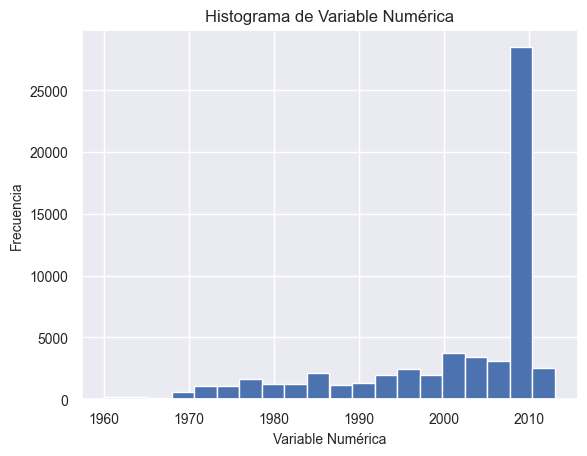

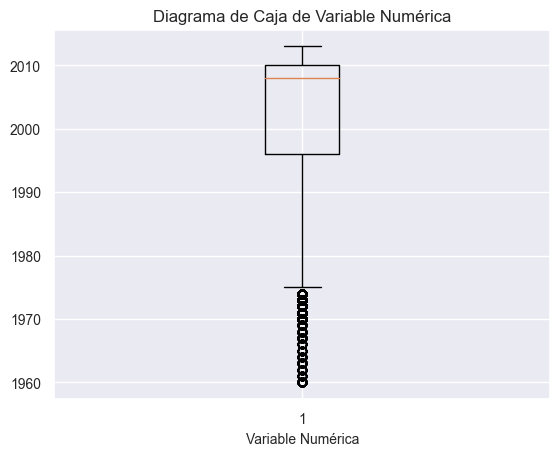

In [37]:
tabla_frecuencias = data_training['construction_year'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
print(tabla_frecuencias)

# histograma
plt.hist(data_training['construction_year'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['construction_year'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

**3. gps_height**

      gps_height  Frecuencia
2316         -90           1
2284         -63           2
2373         -59           1
2314         -57           1
2406         -55           1
...          ...         ...
2362        2623           1
2301        2626           2
2341        2627           1
2358        2628           1
2359        2770           1

[2428 rows x 2 columns]


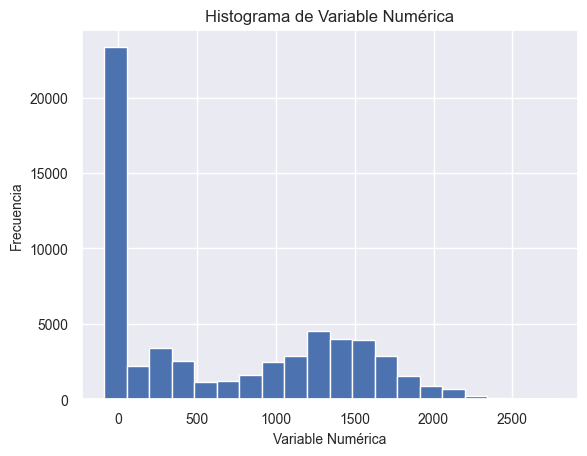

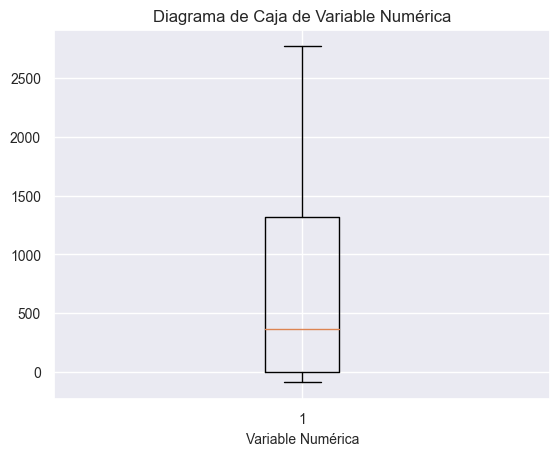

In [38]:
# Exploremos esta variable, que a través del describe, nos percatamos que valores raros (el mínimo es -90, y eso es imposible considerano que hace referencia a la altitud)
tabla_frecuencias = data_training['gps_height'].value_counts().reset_index()
tabla_frecuencias.columns = ['gps_height', 'Frecuencia']
frecuencias_sorted = tabla_frecuencias.sort_values(by='gps_height')
print(frecuencias_sorted)

# histograma
plt.hist(data_training['gps_height'], bins=20)
plt.xlabel('Variable Numérica')
plt.ylabel('Frecuencia')
plt.title('Histograma de Variable Numérica')
plt.show()


# diagrama de caja
plt.boxplot(data_training['gps_height'])
plt.xlabel('Variable Numérica')
plt.title('Diagrama de Caja de Variable Numérica')
plt.show()

In [39]:
# Aplicaremos una transformación logarítmica que considere un 'offset' (o constante) que permita tomar en consideración tanto los valores negativos como los ceros de la variable
# Training


# Calcular el offset basado en el valor mínimo de gps_height
offset = abs(data_training['gps_height'].min()) + 1

# Aplicar transformación logarítmica con offset a la variable
data_training['gps_height_log'] = np.log1p(data_training['gps_height'] + offset)

# Verificamos la diferencia de resultados
print("Media de gps_height antes de la transformación:", data_training['gps_height'].mean())
print("Media de gps_height_log después de la transformación:", data_training['gps_height_log'].mean())



Media de gps_height antes de la transformación: 668.297239057239
Media de gps_height_log después de la transformación: 5.97364723467655


In [40]:
# Test


# Calcular el offset basado en el valor mínimo de gps_height
offset_test = abs(data_test['gps_height'].min()) + 1

# Aplicar transformación logarítmica con offset a la variable
data_test['gps_height_log'] = np.log1p(data_test['gps_height'] + offset_test)

# Verificamos la diferencia de resultados
print("Media de gps_height antes de la transformación:", data_test['gps_height'].mean())
print("Media de gps_height_log después de la transformación:", data_test['gps_height_log'].mean())


Media de gps_height antes de la transformación: 655.1476094276094
Media de gps_height_log después de la transformación: 5.740740453257761


In [41]:
#Verificamos los resultados obtenidos a través de un describe
data_training.describe()

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh_winsor,gps_height_log
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,668.297239,35.149669,-5.706033e+00,15.297003,5.629747,281.055791,2001.411566,22.120149,5.973647
std,21453.128371,693.116350,2.567349,2.946019e+00,17.587406,9.633649,451.765815,11.865943,38.969677,1.279484
min,0.000000,-90.000000,29.607122,-1.164944e+01,1.000000,0.000000,1.000000,1960.000000,0.000000,0.693147
25%,18519.750000,0.000000,33.354079,-8.540621e+00,5.000000,2.000000,100.000000,1996.000000,0.000000,4.521789
50%,37061.500000,369.000000,35.149669,-5.021597e+00,12.000000,3.000000,281.000000,2008.000000,0.000000,6.133398
75%,55656.500000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,281.000000,2010.000000,20.000000,7.252231
max,74247.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000,100.000000,7.959276


In [42]:
# Finalmente eliminamos la variable original (no transformada)
data_training.drop(columns='gps_height', inplace=True)
data_test.drop(columns='gps_height', inplace=True)

**III. Tratamiento de variables categóricas**

In [43]:
pd.set_option('display.max_columns', None)
cat_cols= data_training.select_dtypes(include=['object','category']).columns
data_training[cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,55522,30590,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [44]:
pd.set_option('display.max_columns', None)
cat_cols= data_test.select_dtypes(include=['object','category']).columns
data_test[cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,13980,13973,14850,14850,14751,14850,14850,14850,14029,14850,13881,7608,14113,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,979,1091,10840,9,8443,21,125,1959,2,1,11,1788,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,2215,4349,877,2623,140,1311,625,79,12738,14850,9124,176,9754,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


In [45]:
# Exploramos la cantidad de valores nulos que tiene cada una
data_training.isnull().sum()

id                           0
funder                    3637
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_t

In [46]:
data_test.isnull().sum()

id                          0
funder                    870
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7242
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_cla

**Se convertirán en variables numéricas. Para aquello, se exploraron distintos métodos de conversión. Se aplicó el método de frecuencia, el que a pesar de obtener buenos resultados en training, en test no se obtenian buenas predicciones. Mismo hecho ocurrió con la metodología WoE, que tenía excelentes resultados en el dataset de training original, pero las predicciones no subían den 0,4 en el concurso. Es por esta razón, que de todos los métodos utilizados, el Weight of Evidence presentó las mejores predicciones**

**A continuación, se describe cada variable. Si presenta nulos o no (y en caso de presentar, cómo se trataron estos). En paréntesis, se describe el método de conversión que se utilizó finalmente. Al finalizar la enumeración de todas las variables, se encuentra la fórmula que se aplicó para cada metodología**

**1. funder (LabelEncoder)**

In [47]:
# la variable "funder" que tiene 3637 nulos y 1896 categorías
# Imputación de valores nulos: debido a que puede ser una variable importante, se creará una nueva categoría llamada "Desconocido") para los valores nulos
data_training['funder'].fillna('Desconocido', inplace=True)
data_test['funder'].fillna('Desconocido', inplace=True)

**2. Installer (LabelEncoder)**

In [48]:
#Installer
# Tratamiento de la variasble "installer" que tiene 3655 nulos y 2145 categorías

# Crear una nueva categoría para los valores nulos en la variable
data_training['installer'].fillna('Desconocido', inplace=True)

# Repetimos para el dataset de test
data_test['installer'].fillna('Desconocido', inplace=True)

**3. wpt_name (LabelEncoder)**

In [49]:
#wpt_name
# "wpt_name" solo tiene nulos en el dataset de training: 2 nulos y 37399 categorías. Puede resultar una variable importante
# En función de aquello, se hará una imputación por moda

moda_wpt_name = data_training['wpt_name'].mode()[0]  # Calcula la moda de 'wpt_name'
data_training['wpt_name'] = data_training['wpt_name'].fillna(moda_wpt_name)


**4. basin (LabelEncoder)**

In [50]:
# No presenta nulos en ningún dataset

**5. subvillage (LabelEncoder)**

In [51]:
# Imputacion de valores nulos por la moda

data_training['subvillage'].fillna(data_training['subvillage'].mode()[0], inplace=True)
data_test['subvillage'].fillna(data_training['subvillage'].mode()[0], inplace=True)

**6. region (LabelEncoder)**

In [52]:
# No presenta nulos en ningún dataset

**7. lga (LabelEncoder)**

In [53]:
# No presenta nulos en ningún dataset

**8. ward (LabelEncoder)**

In [54]:
# No presenta nulos en ningún dataset

**9. public_meeting (conversión manual)**

In [55]:
# Presenta nulos en ambos datasets
# Se procederá a imputar por la moda esos valores nulos, en ambos datasets
data_training['public_meeting'].fillna(data_training['public_meeting'].mode()[0], inplace=True)
data_test['public_meeting'].fillna(data_training['public_meeting'].mode()[0], inplace=True)

In [56]:
# Convertir a numérica
data_training['public_meeting'] = data_training['public_meeting'].astype(int)
data_test['public_meeting'] = data_test['public_meeting'].astype(int)

**10. recorded_by (eliminada)**

In [57]:
# Se eliminará esta variable, ya que solo tiene una categoría
data_training = data_training.drop('recorded_by', axis=1)
data_test = data_test.drop('recorded_by', axis=1)

**11. scheme_management (LabelEncoder)**

In [58]:
# Presenta nulos en ambos datasets
# Se procederá a imputar por la moda esos valores nulos, en ambos datasets
data_training['scheme_management'].fillna(data_training['scheme_management'].mode()[0], inplace=True)
data_test['scheme_management'].fillna(data_training['scheme_management'].mode()[0], inplace=True)

**12. scheme_name (LabelEncoder)**

In [59]:
# Esta es una variable que tiene una gran cantidad de valores nulos, en ambos datasets. 

# Vamos a crear una nueva categoría denominada "Desconocidos" para agrupar todos los valores nulos en la variable

#Training
data_training['scheme_name'] = data_training['scheme_name'].fillna('Desconocido')

#Test
data_test['scheme_name'] = data_test['scheme_name'].fillna('Desconocido')

**13. permit (LabelEncoder)**

In [60]:
# Vamos a crear una nueva categoría denominada "Desconocidos" para agrupar todos los valores nulos en la variable

#Training
data_training['permit'] = data_training['permit'].fillna('Desconocido')
data_test['permit'] = data_test['permit'].fillna('Desconocido')

**14. extraction_type (LabelEncoder)**

In [61]:
# No presenta nulos en ningún dataset

**15. extraction_type_group (LabelEncoder)**

In [62]:
# No presenta nulos en ningún dataset

**16. extraction_type_class (LabelEncoder)**

In [63]:
# No presenta nulos en ningún dataset

**17. management (LabelEncoder)**

In [64]:
# No presenta nulos en ningún dataset

**18. management_group (LabelEncoder)**

In [65]:
# No presenta nulos en ningún dataset

**19. payment (LabelEncoder)**

In [66]:
# No presenta nulos en ningún dataset

**20. payment_type (LabelEncoder)**

In [67]:
# No presenta nulos en ningún dataset

**21. water_quality (conversión manual)**

In [68]:
# Dado que se trata de una variable categórica ordinal (ya que parecen estar ordenadas en términos de calidad del agua)
# se va a proceder a convertir la en numérica, asignando un número a cada categoría

# Exploramos la categorías
counts = data_training["water_quality"].value_counts().to_dict()

counts

{'soft': 50818,
 'salty': 4856,
 'unknown': 1876,
 'milky': 804,
 'coloured': 490,
 'salty abandoned': 339,
 'fluoride': 200,
 'fluoride abandoned': 17}

In [69]:
# Mapeo de las categorías a valores numéricos
mapeo_water_quality = {
    'unknown': 0,  
    'fluoride abandoned': 1,
    'salty abandoned': 2,
    'fluoride': 3,
    'coloured': 4,
    'milky': 5,
    'salty': 6,
    'soft': 7
}

# Aplicar el mapeo a la columna 'water_quality'
# Training
data_training['water_quality_numerica'] = data_training['water_quality'].map(mapeo_water_quality)

#Test
data_test['water_quality_numerica'] = data_test['water_quality'].map(mapeo_water_quality)

In [70]:
#Eliminamos las columnas categóricas para mantener solo las numéricas

#Training
data_training = data_training.drop('water_quality', axis=1)

#Test
data_test = data_test.drop('water_quality', axis=1)

**22. quality_group (conversión manual)**

In [71]:
# Dado que se trata de una variable categórica ordinal (ya que parecen estar ordenadas en términos de calidad del agua)
# se va a proceder a convertir la en numérica, asignando un número a cada categoría

# Exploramos la categorías
counts = data_training["quality_group"].value_counts().to_dict()

counts

{'good': 50818,
 'salty': 5195,
 'unknown': 1876,
 'milky': 804,
 'colored': 490,
 'fluoride': 217}

In [72]:
# Mapeo de las categorías a valores numéricos
mapeo_quality_group = {
    'unknown': 0,  
    'fluoride': 1,
    'colored': 2,
    'milky': 3,
    'salty': 4,
    'good': 5
}

# Aplicar el mapeo a la columna 'quality_group'
# Training
data_training['quality_group_numerica'] = data_training['quality_group'].map(mapeo_quality_group)

# Test
data_test['quality_group_numerica'] = data_test['quality_group'].map(mapeo_quality_group)

In [73]:
#Eliminamos las columnas categóricas para mantener solo las numéricas

#Training
data_training = data_training.drop('quality_group', axis=1)

#Test
data_test = data_test.drop('quality_group', axis=1)

**23. quantity (LabelEncoder)**

In [74]:
# No presenta nulos en ningún dataset

**24. quantity_group  (LabelEncoder)**

In [75]:
# No presenta nulos en ningún dataset

**25. source  (LabelEncoder)**

In [76]:
# No presenta nulos en ningún dataset

**26. source_type (LabelEncoder)**

In [77]:
# No presenta nulos en ningún dataset

**27. source_class (conversión manual)**

In [78]:
# Dado la poca cantidad de categorías que tiene, y también atendiendo a la naturaleza de la variable, es que esta variable se convertirá en dummy

In [79]:
# Aplicar one-hot encoding a la columna 'source_class'
#Training
source_class_dummies_training = pd.get_dummies(data_training['source_class'], prefix='source_class')
#Test
source_class_dummies_test = pd.get_dummies(data_test['source_class'], prefix='source_class')

# Unir las columnas dummy al DataFrame original
#Training
data_training = pd.concat([data_training, source_class_dummies_training], axis=1)
#Test
data_test = pd.concat([data_test, source_class_dummies_test], axis=1)

# Eliminar la columna original 'source_class'
#Training
data_training = data_training.drop('source_class', axis=1)
#Test
data_test = data_test.drop('source_class', axis=1)

In [80]:
#Convertir las columnas nuevas (dummies) a numérica. De esta manera, True adquiere valor 1 y False valores 0

# Training
# Convertir las variables dummy a numéricas (True/False a 1/0)
data_training['source_class_groundwater_numeric'] = data_training['source_class_groundwater'].astype(int)
data_training['source_class_surface_numeric'] = data_training['source_class_surface'].astype(int)
data_training['source_class_unknown_numeric'] = data_training['source_class_unknown'].astype(int)

# Sumar las variables dummy convertidas a numéricas para cada observación
data_training['source_class_numeric'] = data_training['source_class_groundwater_numeric'] + data_training['source_class_surface_numeric'] + data_training['source_class_unknown_numeric']

# Test
# Convertir las variables dummy a numéricas (True/False a 1/0)
data_test['source_class_groundwater_numeric'] = data_test['source_class_groundwater'].astype(int)
data_test['source_class_surface_numeric'] = data_test['source_class_surface'].astype(int)
data_test['source_class_unknown_numeric'] = data_test['source_class_unknown'].astype(int)

# Sumar las variables dummy convertidas a numéricas para cada observación
data_test['source_class_numeric'] = data_test['source_class_groundwater_numeric'] + data_test['source_class_surface_numeric'] + data_test['source_class_unknown_numeric']

In [81]:
# Eliminamos columnas booleanas para mantener solo las numéricas


# Crear una lista con los nombres de las columnas booleanas
columnas_booleanas_training = ['source_class_groundwater', 'source_class_surface', 'source_class_unknown', 'source_class_numeric']
columnas_booleanas_test = ['source_class_groundwater', 'source_class_surface', 'source_class_unknown', 'source_class_numeric']

# Eliminar las columnas booleanas del DataFrame
data_training = data_training.drop(columnas_booleanas_training, axis=1)
data_test = data_test.drop(columnas_booleanas_test, axis=1)

**28. waterpoint_type (LabelEncoder)**

In [82]:
# No presenta nulos en ningún dataset

**Ahora verificamos que no existan nulos en ninguna variable categórica**

In [83]:
data_training.isnull().sum()

id                                  0
funder                              0
installer                           0
longitude                           0
latitude                            0
wpt_name                            0
basin                               0
subvillage                          0
region                              0
region_code                         0
district_code                       0
lga                                 0
ward                                0
population                          0
public_meeting                      0
scheme_management                   0
scheme_name                         0
permit                              0
construction_year                   0
extraction_type                     0
extraction_type_group               0
extraction_type_class               0
management                          0
management_group                    0
payment                             0
payment_type                        0
quantity    

In [84]:
# Hacemos join del dataframe con las labels (respuestas)
data2 = pd.merge(data_training, data_labels,  on = "id", how = "left")

**Finalmente, se listan abajo las variables que aún no han sido convertidas a numéricas**

In [85]:
categorical_features = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
                        'lga', 'ward', 'scheme_management', 'scheme_name', 'permit', 
                        'extraction_type', 'extraction_type_group', 'extraction_type_class', 
                        'management', 'management_group', 'payment', 'payment_type', 
                        'quantity', 'quantity_group', 'source', 'source_type', 
                        'waterpoint_type', 'waterpoint_type_group']

**A. Metodología de conversión a través de la frecuencia (descartada finalmente, ya que no hacia buenas predicciones sobre el modelo de test original)**

**B. Metodología de conversión a través de WoE (weight of evidence): descartada finalmente, ya que no hacia buenas predicciones sobre el modelo de test original**

**C. Metodología de conversión a través de LabelEncoder: La que se utilizó finalmente, ya que hacía mucho mejores predicciones sobre el modelo de test original**

In [86]:
from sklearn.preprocessing import LabelEncoder

#Dataset de training

# Convertir las columnas categóricas a tipo 'object'
data2[categorical_features] = data2[categorical_features].astype(str)

# Aplicar Label Encoding a las variables categóricas
label_encoder = LabelEncoder()
for feature in categorical_features:
    data2[feature] = label_encoder.fit_transform(data2[feature])





In [87]:
from sklearn.preprocessing import LabelEncoder

#Dataset de test


# Convertir las columnas categóricas a tipo 'object'
data_test[categorical_features] = data_test[categorical_features].astype(str)

# Aplicar Label Encoding a las variables categóricas
label_encoder = LabelEncoder()
for feature in categorical_features:
    data_test[feature] = label_encoder.fit_transform(data_test[feature])



**CON ESTO, SE TERMINA EL PRE-PROCESADO DE DATOS**

**Aplicación de un modelo de Machine Learning**

In [88]:
# Vamos a trabajar solo con el dataset de training. Este lo dividiremos en un dataset de training (valga la redundancia) y otro de test, para entrenar un modelo
# Finalmente, aplicaremos este modelo entrenado al dataset de 'test' original del concurso

In [89]:
#Convertimos a numérica la variable objetivo

# Crear un diccionario de mapeo para asignar números a cada categoría
mapeo_categorias = {'non functional': 0, 'functional needs repair': 1, 'functional': 2 }

# Aplicar el mapeo a la columna 'status_group'
data2['status_group_numeric'] = data2['status_group'].map(mapeo_categorias)

# Eliminar la columna categórica
data2 = data2.drop('status_group', axis=1)


In [90]:
# Antes de dividir el dataset, vamos a definir el 'id' como índice
data2.set_index('id', inplace=True)

In [91]:
# Se aplicará un modelo Random Forest. Primero, dividimos en train y test

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split (data2.drop('status_group_numeric', axis=1), 
                                                     data2.status_group_numeric,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = data2.status_group_numeric)


**1. XGBoost**

**Primero se entrenó un modelo XGBoost. Las predicciones si bien no eran malas sobre el dataset de test original del concurso, a través de un Random Forest se obtuvieron mejores resultados. El puntaje obtenido con este modelo (XGBoost) fue de 0.7391. El código utilizado es el siguiente:**

**2. Random Forest (modelo con mejores resultados)**

**La celda anterior se dejó como Raw, debido a que tarda mucho en ejecutar. No obstante, los resultados arrojaron lo siguiente:**

In [92]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Definir los hiperparámetros personalizados en base a los resultados del código anterior
n_estimators = 100
max_depth = None
min_samples_split = 5


# Crear el clasificador de Random Forest con los hiperparámetros personalizados
rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=42)



# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred = rf_classifier.predict(X_test)

In [93]:

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calcular precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calcular recall
recall = recall_score(y_test, y_pred, average='weighted')

# Calcular F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.813047138047138
Precision: 0.8084555796532856
Recall: 0.813047138047138
F1-score: 0.8044701999331735
Confusion Matrix:
 [[3510   60  995]
 [ 127  270  466]
 [ 459  114 5879]]


In [94]:
#Seteamos el índex también para el dataset de test
data_test.set_index('id', inplace=True)

In [95]:
# Predecir sobre los datos de prueba
predicciones_data_test = rf_classifier.predict(data_test)


In [96]:
#Reseteamos index para convertir en dataframe
data_test.reset_index('id', inplace=True)

In [97]:

# Almacenar como DF
result_df = pd.DataFrame({'id': data_test['id'], 'status_group': predicciones_data_test})

# Guardar el DataFrame como un archivo Excel
result_df.to_excel('prediccion_RF_FelipeMancilla_ML.xlsx', index=False)

In [98]:
# Cargar el archivo Excel con las predicciones
predicciones_df = pd.read_excel('prediccion_RF_FelipeMancilla_ML.xlsx')

# Reemplazar los valores en la columna "status_group"
predicciones_df["status_group"] = predicciones_df["status_group"].replace({0: "non functional",
                                                                         1: "functional needs repair",
                                                                         2: "functional"})

# Guardar el archivo modificado como CSV
predicciones_df.to_csv("predicciones_modificadas.csv", index=False, sep=",")

**Evaluación del modelo por si existiese sobreentrenamiento**

In [99]:
#Aplicaremos validación cruzada sobre el modelo, para verificar que no haya existido sobreentrenamiento

In [100]:

# Extraer la variable objetivo 'y'
y = data2['status_group_numeric']

# Eliminar la variable objetivo 'y' del DataFrame 'data' para dejar solo las características
X = data2.drop('status_group_numeric', axis=1)

In [101]:
# Aplicar validación cruzada
puntuaciones_validacion_cruzada = cross_val_score(rf_classifier, X, y, cv=5) 

# Calcular la media y la desviación estándar de las puntuaciones de validación cruzada
media_puntuaciones = np.mean(puntuaciones_validacion_cruzada)
desviacion_estandar_puntuaciones = np.std(puntuaciones_validacion_cruzada)

# Imprimir resultados
print("Puntuaciones de validación cruzada:", puntuaciones_validacion_cruzada)
print("Media de las puntuaciones:", media_puntuaciones)
print("Desviación estándar de las puntuaciones:", desviacion_estandar_puntuaciones)

Puntuaciones de validación cruzada: [0.81885522 0.81245791 0.81262626 0.81060606 0.81372054]
Media de las puntuaciones: 0.8136531986531986
Desviación estándar de las puntuaciones: 0.0027868945382727747


In [102]:
#Los resultados de la validación cruzada indican que la media de las puntuaciones es alta, por lo que se puede decir que el modelo tiene un buen rendimiento en general
# Asimismo, la desviación estándar es baja, lo cual también es un buen indicador de la consistencia